In [ ]:
# Running the same Code on Test will show us how even a perfect model could potentially be 
# not be ideal, since it leads to overfitting. And why is it so hard to avoid, and what ml is trying to overcome.

import numpy as np 
import pandas as pd
from pandas.plotting import lag_plot
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score # pip install scikit-learn
import yfinance_fix

[*********************100%***********************]  1 of 1 completed

Nr. of Rows (All): 8241
Nr. of Training Rows: 5768
Nr. of Testing Rows: 2472


Price,Close,High,Low,Open,Volume,Close_Change,High_Change,Low_Change,Open_Change,Volume_Change,...,Upper Band,Lower Band,BB,gain,loss,avg_gain,avg_loss,RSI,Close + 1,Target
0,91.040764,91.220956,90.770470,90.846707,42921400,0.359086,0.228445,0.398628,-0.053363,-29.430315,...,91.698666,88.995332,0.243367,0.325745,-0.000000,0.249502,0.118314,67.833379,91.844711,1
1,57.699390,57.910884,57.468670,57.910884,941800,0.401498,-0.330880,0.167587,-0.330880,-53.357765,...,61.033047,57.272099,0.886387,0.230736,-0.000000,0.119863,0.329230,26.690046,58.833771,1
2,150.207779,150.403260,149.727234,150.093751,72290600,-0.129961,-0.151389,0.065329,0.097780,-26.627746,...,151.107808,147.145997,0.227176,0.000000,0.195465,0.326963,0.294383,52.621701,149.572495,0
3,32.950432,33.069718,32.849498,32.968783,951900,0.000000,0.055525,-0.250766,0.055695,392.957017,...,33.280992,32.503360,0.425086,0.000000,-0.000000,0.070787,0.035394,66.666153,32.941269,0
4,59.209236,59.789271,59.137546,59.548136,32353900,-0.872907,-0.054493,1.204526,1.725659,-12.788961,...,61.990348,57.938829,0.686437,0.000000,0.521393,0.322142,0.361710,47.106979,58.524963,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8236,158.495605,159.860503,157.493000,158.621992,159045600,0.058472,-1.130773,-0.378424,-1.830255,-10.906760,...,168.614773,158.590640,1.009481,0.092621,-0.000000,0.433808,0.774584,35.899631,161.452896,1
8237,81.566628,81.856948,81.046753,81.505865,51641800,-0.057959,0.107288,-0.224468,0.016523,10.583907,...,81.762545,78.932715,0.069233,0.000000,0.047302,0.207376,0.088738,70.032446,81.022621,0
8238,57.731857,58.020022,56.552986,57.194817,67321600,0.215886,0.487617,-0.380836,0.057167,35.644801,...,57.909415,52.338529,0.031872,0.124367,-0.000000,0.416346,0.264313,61.168074,58.964161,1
8239,171.164612,171.271976,170.875574,171.090289,65880800,0.280662,-0.216477,0.451538,-0.226320,-53.711762,...,172.025238,163.634369,0.102567,0.479050,-0.000000,0.397584,0.032438,92.456665,171.040665,0


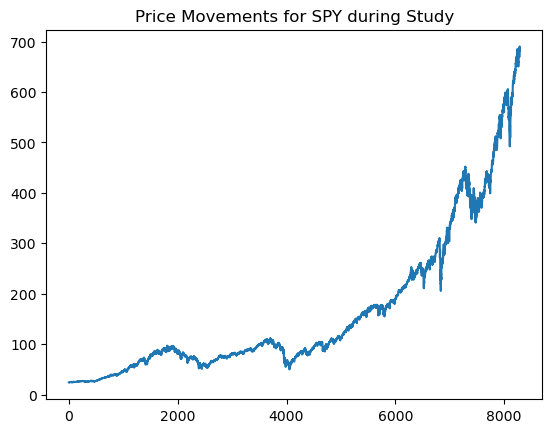

In [ ]:
TICKER = "SPY"
INTERVAL = "1d"
PERIOD = "730d" if INTERVAL == "1h" else "max"

#   MACD
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9
#   MFI
MFI_LENGTH = 14 
OVERBROUGHT = 70
OVERSOLD = 30 
#   BB
BB_LENGTH = 20
STD_DEV = 2
#   RSI
RSI_LENGTH = 14
RSI_OVERBROUGHT = 70
RSI_OVERSOLD = 30

STRATEGY = ['Volume_Change', 'Close_Change' , 'High_Change', 'Low_Change', 'Open_Change', "MACD_HIST", "MFI", "BB", "RSI"]
SHIFT_RANGE = range(1, 120)
SHIFT = 1
OPTIMAL_SHIFT = None
LOOKBACK = 10000

# Train Test Split
TRAIN_SIZE = .7

# --- (1) Daten herunterladen ---

def get_data(ticker=TICKER, interval=INTERVAL, lookback=LOOKBACK):
    df = yf.download(ticker, session=yfinance_fix.chrome_session, interval = interval, period = PERIOD)
    # WICHTIG: Prüfen, ob überhaupt Daten da sind!
    if df.empty:
        print(f"WARNUNG: Keine Daten für {ticker} erhalten!")
        return df # Gibt leeren DF zurück, damit main() das abfangen kann
    df.columns = df.columns.get_level_values(0)
    df = df.reset_index(drop=True)

    for c in df.columns:
        df[f"{c}_Change"] = df[f"{c}"].pct_change() * 100

    subset = df.iloc[-lookback:,:]
    plt.figure()
    plt.plot(subset["Close"])
    plt.title(f"Price Movements for {ticker} during Study")
    
    return df.iloc[-lookback:, :].dropna()

# --- (2) Unabhängige Variablen ("Features") definieren ---

def add_MACD(df, fast = MACD_FAST, slow = MACD_SLOW, span = MACD_SPAN):
    df[f"{fast}_ema"] = df["Close"].ewm(span = fast).mean()
    df[f"{slow}_ema"] = df["Close"].ewm(span = slow).mean()
    df["MACD"] = df[f"{fast}_ema"] - df[f"{slow}_ema"]
    df["Signal"] = df[f"MACD"].ewm(span = span).mean()
    df["MACD_HIST"] = df[f"MACD"] - df["Signal"]

    return df

def add_MFI(df, length = MFI_LENGTH):
    df["Average_Price"] = (df["High"]+df["Low"]+df["Close"])/3
    df["Money_Flow"] = df["Volume"]*df["Average_Price"]
    df["Pos_Flow"] = np.where(df["Average_Price"].diff()>0, df["Average_Price"], 0)
    df["Neg_Flow"] = np.where(df["Average_Price"].diff()<0, df["Average_Price"], 0)
    df["MFR"] = df["Pos_Flow"].rolling(window=length).sum() / df["Neg_Flow"].rolling(window=length).sum()
    df["MFI"] = (100 - 100 / (1 + df["MFR"]))

    return df.dropna()

def add_BB(df, std_dev = STD_DEV, length = BB_LENGTH):
    df["BB_SMA"] = df["Close"].rolling(window=length).mean()
    df["BB_STD"] = df["Close"].rolling(window=length).std()
    df["Upper Band"] = df["BB_SMA"] + (std_dev * df["BB_STD"])
    df["Lower Band"] = df["BB_SMA"] - (std_dev * df["BB_STD"])
    df["BB"] = ((df["Close"] - df["Lower Band"])/(df["Upper Band"] - df["Lower Band"]))


    return df.dropna()

def add_RSI(df, length = RSI_LENGTH, overbrought = RSI_OVERBROUGHT, oversold = RSI_OVERSOLD):
    price_change = df["Close"].diff()
    df["gain"] = price_change.where(price_change > 0, 0)
    df["loss"] = - price_change.where(price_change < 0, 0)
    df["avg_gain"] = df["gain"].rolling(window = length).mean()
    df["avg_loss"] = df["loss"].rolling(window = length).mean()
    rs = df["avg_gain"] / df["avg_loss"]
    df["RSI"] = 100 - (100/(1+rs))

    return df.dropna()


# --- (3) Add Target ---
def add_target(df, shift=SHIFT):
    df = df.copy()
    df[f"Close + {shift}"] = df["Close"].shift(-shift)
    df["Target"] = (df[f"Close + {shift}"] > df["Close"]) * 1
    return df.dropna().reset_index(drop=True)

# --- (4) Add Train Test Split Function ---
def train_test_split(df, train_size=TRAIN_SIZE):
    # Once we have our weights and bias determined in the training set, we will be aplying this data to teh tesing set
    df = df.sample(frac=1).reset_index(drop=True)

    split = int((len(df) * .7))
    all_rows = int((len(df)))
    test_nr = int((len(df) * .3))
    print(f"Nr. of Rows (All): {all_rows}")
    print(f"Nr. of Training Rows: {split}")
    print(f"Nr. of Testing Rows: {test_nr}")

    train = df.iloc[:split, :]
    test = df.iloc[split:, :] # Our future data, not included in the training of the model
    

    return df, train, test 

def main():
    global OPTIMAL_SHIFT

    # Load and process data once:
    df = get_data()
    df = add_MACD(df)
    df = add_MFI(df)
    df = add_BB(df)
    df = add_RSI(df)
    df = add_target(df)
    df, train, test = train_test_split(df)

    return df, train, test

df, train, test = main()
df


In [ ]:
train 

Price,Close,High,Low,Open,Volume,Close_Change,High_Change,Low_Change,Open_Change,Volume_Change,...,Upper Band,Lower Band,BB,gain,loss,avg_gain,avg_loss,RSI,Close + 1,Target
0,91.040764,91.220956,90.770470,90.846707,42921400,0.359086,0.228445,0.398628,-0.053363,-29.430315,...,91.698666,88.995332,0.243367,0.325745,-0.000000,0.249502,0.118314,67.833379,91.844711,1
1,57.699390,57.910884,57.468670,57.910884,941800,0.401498,-0.330880,0.167587,-0.330880,-53.357765,...,61.033047,57.272099,0.886387,0.230736,-0.000000,0.119863,0.329230,26.690046,58.833771,1
2,150.207779,150.403260,149.727234,150.093751,72290600,-0.129961,-0.151389,0.065329,0.097780,-26.627746,...,151.107808,147.145997,0.227176,0.000000,0.195465,0.326963,0.294383,52.621701,149.572495,0
3,32.950432,33.069718,32.849498,32.968783,951900,0.000000,0.055525,-0.250766,0.055695,392.957017,...,33.280992,32.503360,0.425086,0.000000,-0.000000,0.070787,0.035394,66.666153,32.941269,0
4,59.209236,59.789271,59.137546,59.548136,32353900,-0.872907,-0.054493,1.204526,1.725659,-12.788961,...,61.990348,57.938829,0.686437,0.000000,0.521393,0.322142,0.361710,47.106979,58.524963,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5763,80.319122,80.670543,79.791991,80.358169,6159700,-0.723957,-0.289594,-0.024481,0.439220,-7.227845,...,83.308537,76.575533,0.443994,0.000000,0.585716,0.448329,0.426101,51.271012,81.939545,1
5764,163.137329,163.426380,161.906829,162.030700,95112000,-0.181928,-0.252046,-0.188387,-0.254211,-8.146059,...,166.231165,162.533871,0.836784,0.000000,0.297333,0.407757,0.458052,47.095485,162.707977,0
5765,39.100979,39.259471,38.951810,39.007748,561900,0.215123,0.357553,0.239993,-0.095442,204.718004,...,39.557424,37.621764,0.235809,0.083935,-0.000000,0.129859,0.018647,87.443694,38.429722,0
5766,93.759705,93.790590,92.192282,93.157444,326777200,1.725757,0.554666,2.296126,1.952039,2.313069,...,95.492616,86.741527,0.198022,1.590614,-0.000000,0.813493,0.529459,60.575013,94.314621,1


In [ ]:
# Out of sample data we need to prove that teh pattern we identified can be used for 
# future analysis 
test

Price,Close,High,Low,Open,Volume,Close_Change,High_Change,Low_Change,Open_Change,Volume_Change,...,Upper Band,Lower Band,BB,gain,loss,avg_gain,avg_loss,RSI,Close + 1,Target
5768,80.898193,81.095689,80.367000,80.421477,77944900,1.029100,1.172491,1.592644,1.443183,27.628300,...,80.792908,77.902112,-0.036421,0.824043,-0.000000,0.376507,0.153229,71.074408,81.238670,1
5769,58.873631,60.534605,58.231303,59.989596,48880600,0.198757,0.995886,-0.133536,1.470577,-8.261265,...,67.125648,57.884432,0.892958,0.116783,-0.000000,0.346194,0.669676,34.078596,56.966099,0
5770,80.237587,80.414653,79.713205,79.822165,43750500,0.623446,0.076273,-0.008546,-0.610541,-35.103107,...,80.850110,77.228582,0.169134,0.497139,-0.000000,0.362397,0.245167,59.647587,79.406776,0
5771,189.845657,190.026390,189.114086,189.785404,67429000,0.195305,0.277027,0.333312,0.611376,-6.869367,...,191.323643,178.592194,0.116089,0.370056,-0.000000,0.825621,0.159218,83.833115,189.948914,1
5772,102.676361,102.762277,102.160868,102.488906,126328900,0.527655,0.557951,1.332517,1.477082,-22.685061,...,102.901365,96.259236,0.033875,0.538933,-0.000000,0.460258,0.090377,83.586809,103.059090,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8236,158.495605,159.860503,157.493000,158.621992,159045600,0.058472,-1.130773,-0.378424,-1.830255,-10.906760,...,168.614773,158.590640,1.009481,0.092621,-0.000000,0.433808,0.774584,35.899631,161.452896,1
8237,81.566628,81.856948,81.046753,81.505865,51641800,-0.057959,0.107288,-0.224468,0.016523,10.583907,...,81.762545,78.932715,0.069233,0.000000,0.047302,0.207376,0.088738,70.032446,81.022621,0
8238,57.731857,58.020022,56.552986,57.194817,67321600,0.215886,0.487617,-0.380836,0.057167,35.644801,...,57.909415,52.338529,0.031872,0.124367,-0.000000,0.416346,0.264313,61.168074,58.964161,1
8239,171.164612,171.271976,170.875574,171.090289,65880800,0.280662,-0.216477,0.451538,-0.226320,-53.711762,...,172.025238,163.634369,0.102567,0.479050,-0.000000,0.397584,0.032438,92.456665,171.040665,0
